In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import statsmodels.api as sm

%matplotlib inline
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 1000)
pd.options.display.max_seq_items = 1000

In [2]:
curr_dir = os.getcwd()
data_path = os.path.join(curr_dir, "datasets", "listings_clean.csv")
df = pd.read_csv(data_path)

In [3]:
df.sample(2)

,id,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,...,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,amenities_len
75869,34704605,20190710134553,2019-07-11,Canary Wharf/ Large double room,"The apartment is located in East London, Isle ...",I provide towels/ shampoo/ shower gel/ toilet ...,"The apartment is located in East London, Isle ...",none,"Peaceful, quiet location. Beautiful landscape...",.,...,f,moderate,f,f,30,0,30,0,1.71,15
59226,28957118,20190710134553,2019-07-10,"New, bright and spacious flat in East London",A brand new flat with balcony in a stunning ap...,.,A brand new flat with balcony in a stunning ap...,none,Barking town centre is home to an array of ind...,.,...,f,moderate,f,f,1,1,0,0,1.15,15


## Create baseline model first before feature engineering

In [4]:
# Check correlation of every feature wrt to target variable price
pd.set_option('display.float_format', lambda x: '%.3f' % x)
corr = df.corr()
corr["price"].sort_values(ascending=False)

price                                           1.000
accommodates                                    0.547
bedrooms                                        0.494
cleaning_fee                                    0.464
beds                                            0.442
bathrooms                                       0.394
guests_included                                 0.334
security_deposit                                0.296
host_listings_count                             0.238
host_total_listings_count                       0.238
calculated_host_listings_count_entire_homes     0.229
calculated_host_listings_count                  0.225
amenities_len                                   0.147
availability_365                                0.123
availability_60                                 0.108
id                                              0.105
availability_90                                 0.100
availability_30                                 0.091
host_id                     

In [5]:
# Will only use accommodates feature for the baseline model as it is weakly correlated with price
X = df["accommodates"].values.reshape(-1, 1)
y = df["price"].values.reshape(-1, 1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
linreg = LinearRegression(fit_intercept=True)
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [8]:
y_pred = linreg.predict(X_test)

In [9]:
print("##### MODEL PERFORMANCE #####")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

# Return R^2 values for the training and testing data
print("Training score: ", linreg.score(X_train, y_train))
print("Testing score: ", r2_score(y_test, y_pred))
print("Average price: {:.2f} +/- {:.2f}".format(np.mean(y_test), np.sqrt(mean_squared_error(y_test, y_pred))))

##### MODEL PERFORMANCE #####
MAE: 50.66724358451496
MSE: 7721.660568284178
RMSE: 87.87297973941807
Training score:  0.29934618153945125
Testing score:  0.3004210463537438
Average price: 110.87 +/- 87.87


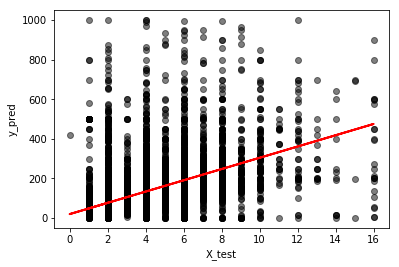

In [10]:
plt.scatter(X_test, y_test, color="k", alpha=0.5)
plt.plot(X_test, y_pred, color="red", linewidth=2)
plt.xlabel("X_test")
plt.ylabel("y_pred")
plt.show()

In [11]:
print("Coeff:", linreg.coef_)
print("Intercept:", linreg.intercept_)

Coeff: [[28.48142266]]
Intercept: [19.62533969]


In [12]:
from sklearn.model_selection  import learning_curve
from sklearn.model_selection  import KFold

size = 10
cv = KFold(size, shuffle=True)

No handles with labels found to put in legend.


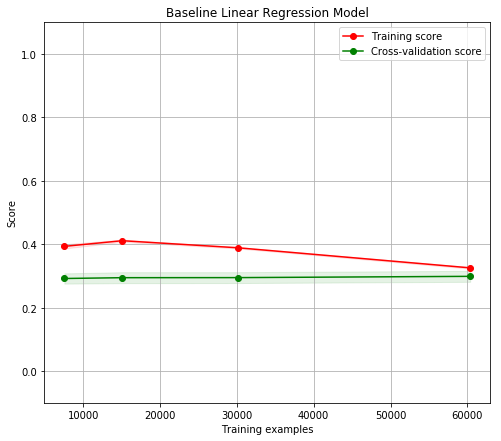

In [13]:
def plot_learning_curves(model, name):
    model.fit(X, y)
    train_sizes, train_scores, test_scores = learning_curve(model, 
                                                            X, 
                                                            y, 
                                                            n_jobs=-1, 
                                                            cv=cv, 
                                                            train_sizes=[0.1, 0.2, 0.4, 0.8], 
                                                            verbose=0)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(8, 7))
    plt.title(name)
    plt.legend(loc="best")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.gca().invert_yaxis()
    
    plt.grid()
    
    # plot the std deviation as a transparent range at each training set size
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    # plot the average training and test score lines at each training set size
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    # sizes the window for readability and displays the plot
    # shows error from 0 to 1.1
    plt.ylim(-0.1, 1.1)
    plt.legend(loc="best")
    plt.show()
plot_learning_curves(LinearRegression(fit_intercept=True), 
                     "Baseline Linear Regression Model")

Key terms:
- Bias of an estimator is its average error for varying training sets
- Variance of an estimator indicates sensitivity to varying training sets

From the above plot, training score (red line) decreases with training examples indicating underfitting and high bias. Stagnant cross-validation score (green line) indicates that the model is unable to learn from the data. The baseline low scores in this model indicates that we should increase model complexity to correct for high bias.

## Feature engineering
### Strategy


**Feature extraction/Feature engineering:**

- Calculate distance from a key central landmark in London such as the Big Ben, and then calculate the distance of every listed property from here
- Create a column to encode "strictness of house rules" -> this will be one-hot encoded 

**Feature Selection and transformations**

- Check for multicollinearity
- Implement transformations to adjust for non-normality of data
- room_type one hot encoding
- property_type one hot encoding
- bed_type one hot encoding
- neighbourhood_cleansed one hot encoding
- Standardize data

### Engineered Feature 1: Distance of each listing from a key landmark (Big ben)

In [17]:
# !pip install geopy

In [18]:
import geopy.distance

def haversine_distance(row):
    """
    Calculate the great circle distance using haversine formula 
    between two points on the earth, latitude and longitude 
    (specified in decimal degrees).
    
    Returns dataframe consisting of distance in km.
    Can verify calculation from: https://www.nhc.noaa.gov/gccalc.shtml
    """
    key_landmark = (51.5007, 0.1245)
    coords = (row['latitude'], row['longitude'])
    d = geopy.distance.distance(key_landmark, coords).km
    return(d)

# Canary Wharf
sample = pd.DataFrame({"latitude" :[51.50], 
                      "longitude" : [0.022]})

assert int(sample.apply(haversine_distance, axis=1)) == 7 # Distance between Big Ben and Canary Wharf

In [35]:
%%time
df["dist_to_bigben"] = df.apply(haversine_distance, axis=1)

Wall time: 22.8 s


In [20]:
df[["latitude", "longitude", "dist_to_bigben"]].sample(5)

,latitude,longitude,dist_to_bigben
14702,51.511,-0.126,17.401
64090,51.406,-0.213,25.691
54499,51.544,-0.075,14.649
38855,51.503,-0.091,14.988
76650,51.489,-0.008,9.315


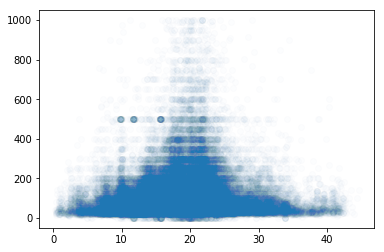

In [21]:
plt.scatter(df["dist_to_bigben"], df["price"], alpha=0.01)
plt.show()

Based on the plot above, it seems that the price increases the closer the listing is near the landmark (big ben), and decreases the further it is away from it radially. The distribution seems symmetrical, hence we can mirror and overlap the data from the midpoint to achieve an artificial transformation. 

In [22]:
df = df.sort_values(by=["dist_to_bigben"], ascending=True).reset_index()

In [23]:
np.median(df["dist_to_bigben"])

18.23300998683952

In [24]:
mid = int(df.shape[0] / 2)
end = int(df.shape[0])

In [25]:
transformed_dist = pd.DataFrame(df["dist_to_bigben"])

In [26]:
# Artificial transformation based on mirror at the midpoint
transformed_dist.loc[mid:end, "dist_to_bigben"] = transformed_dist.loc[0:mid-1, "dist_to_bigben"].values

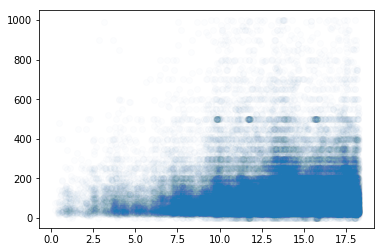

In [27]:
plt.scatter(transformed_dist["dist_to_bigben"], df["price"], alpha=0.01)
plt.show()

In [28]:
df["dist_to_bigben_transformed"] = transformed_dist["dist_to_bigben"]

### Engineered Feature 2: Strictness of house rules

In [29]:
rules = ["no pets", "no friends", "no parties", "no smoking"]
matches = [df["house_rules"].str.contains(x) for x in rules]
df1 = pd.concat(matches, axis=1, keys=rules).astype(int)
df = df.join(df1, how="left")

In [30]:
df[["no pets", "no friends", "no parties", "no smoking"]].sample(5)

,no pets,no friends,no parties,no smoking
58075,0,0,0,0
8127,0,0,0,0
64767,0,0,0,0
61515,0,0,0,1
29295,0,0,0,0


### Engineered Feature 3: One-hot encoding

In [31]:
df = pd.get_dummies(df, columns=["room_type", "property_type", "bed_type", "neighbourhood_cleansed"])

In [32]:
# df.drop(columns=["index", "room_type", "property_type", "bed_type", "neighbourhood_cleansed"], axis=1, inplace=True)

### Save selected and engineered features to disk for model building

In [33]:
feature_cols = ['price', 'accommodates', 'bathrooms', 'bedrooms', 'beds','number_of_reviews',
       'security_deposit', 'cleaning_fee', 'dist_to_bigben', 'dist_to_bigben_transformed',
       'minimum_nights', 'maximum_nights', 'no pets', 'no friends',
       'no parties', 'no smoking', 'room_type_Private room',
       'room_type_Shared room', 'property_type_Apartment',
       'property_type_Barn', 'property_type_Bed and breakfast',
       'property_type_Boat', 'property_type_Boutique hotel',
       'property_type_Bungalow', 'property_type_Bus', 'property_type_Cabin',
       'property_type_Camper/RV', 'property_type_Campsite',
       'property_type_Casa particular (Cuba)', 'property_type_Chalet',
       'property_type_Condominium', 'property_type_Cottage',
       'property_type_Dome house', 'property_type_Earth house',
       'property_type_Farm stay', 'property_type_Guest suite',
       'property_type_Guesthouse', 'property_type_Hostel',
       'property_type_Hotel', 'property_type_House', 'property_type_Houseboat',
       'property_type_Hut', 'property_type_Island', 'property_type_Lighthouse',
       'property_type_Loft', 'property_type_Nature lodge',
       'property_type_Other', 'property_type_Parking Space',
       'property_type_Plane', 'property_type_Ryokan (Japan)',
       'property_type_Serviced apartment', 'property_type_Tent',
       'property_type_Tiny house', 'property_type_Townhouse',
       'property_type_Treehouse', 'property_type_Villa', 'property_type_Yurt',
       'bed_type_Couch', 'bed_type_Futon', 'bed_type_Pull-out Sofa',
       'bed_type_Real Bed', 'neighbourhood_cleansed_Barnet',
       'neighbourhood_cleansed_Bexley', 'neighbourhood_cleansed_Brent',
       'neighbourhood_cleansed_Bromley', 'neighbourhood_cleansed_Camden',
       'neighbourhood_cleansed_City of London',
       'neighbourhood_cleansed_Croydon', 'neighbourhood_cleansed_Ealing',
       'neighbourhood_cleansed_Enfield', 'neighbourhood_cleansed_Greenwich',
       'neighbourhood_cleansed_Hackney',
       'neighbourhood_cleansed_Hammersmith and Fulham',
       'neighbourhood_cleansed_Haringey', 'neighbourhood_cleansed_Harrow',
       'neighbourhood_cleansed_Havering', 'neighbourhood_cleansed_Hillingdon',
       'neighbourhood_cleansed_Hounslow', 'neighbourhood_cleansed_Islington',
       'neighbourhood_cleansed_Kensington and Chelsea',
       'neighbourhood_cleansed_Kingston upon Thames',
       'neighbourhood_cleansed_Lambeth', 'neighbourhood_cleansed_Lewisham',
       'neighbourhood_cleansed_Merton', 'neighbourhood_cleansed_Newham',
       'neighbourhood_cleansed_Redbridge',
       'neighbourhood_cleansed_Richmond upon Thames',
       'neighbourhood_cleansed_Southwark', 'neighbourhood_cleansed_Sutton',
       'neighbourhood_cleansed_Tower Hamlets',
       'neighbourhood_cleansed_Waltham Forest',
       'neighbourhood_cleansed_Wandsworth',
       'neighbourhood_cleansed_Westminster']

In [34]:
df[feature_cols].to_csv(os.path.join(curr_dir, "datasets", "listings_engineered.csv"), index=False)